# Brain Tumor Classification

## Clone the Github Repo to access the Dataset

In [8]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive

!ls /mydrive


/content/gdrive/MyDrive/Brain_tumor
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
ln: failed to create symbolic link '/mydrive/My Drive': File exists
 Brain_tumor  'Colab Notebooks'  'My Drive'   yolov4


In [2]:
%cd /mydrive/Brain_tumor/

/content/gdrive/My Drive/Brain_tumor


## Import necessary Libraries 

In [33]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils    


## Creating Directories to store Cropped Images

In [34]:
# Create Directory for Training Data of 4 different Tumors
os.mkdir("Crop-Brain-MRI")
os.mkdir("Crop-Brain-MRI/glioma_tumor")  
os.mkdir("Crop-Brain-MRI/meningioma_tumor")  # Tumor that forms in the meninges(Layers of the brain)
os.mkdir("Crop-Brain-MRI/no_tumor")
os.mkdir("Crop-Brain-MRI/pituitary_tumor")




FileExistsError: ignored

In [16]:
# Create Directory for Testing Data
os.mkdir("Test-data-MRI")
os.mkdir("Test-data-MRI/glioma_tumor")
os.mkdir("Test-data-MRI/meningioma_tumor")
os.mkdir("Test-data-MRI/no_tumor")
os.mkdir("Test-data-MRI/pituitary_tumor")


## Data Visualization

<class 'list'>
5
5
5
5


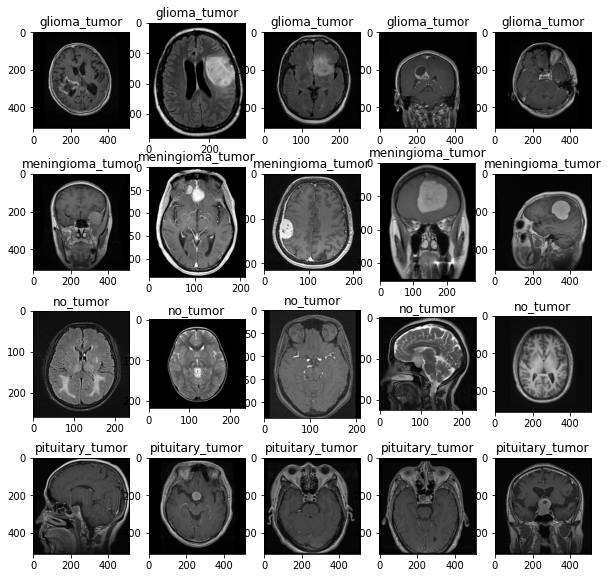

In [17]:
train_dir ="Brain-MRI/Training/"
test_dir="Brain-MRI/Testing/"
classes = os.listdir("Brain-MRI/Training")
print(type(classes))
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir+c+"/"+x,os.listdir(train_dir+c)))
#print(files_path_dict['glioma_tumor'])

plt.figure(figsize=(10,10))
index=0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]
  print(len(path_list))


  for i in range(0,5):
    index += 1
    plt.subplot(4,5,index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)


## Create a Function to Crop Images

In [18]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)
    #print(c.shape)
    #print("a",c[:,:,0][0])
    #print(c[:, :, 0].argmin())
    #print(c[c[:, :, 0].argmin()][0][1])

    extLeft = tuple(c[c[:,:, 0].argmin()][0])
    #print("c",extLeft)
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image

  

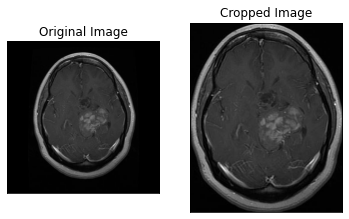

array([[[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [2, 2, 2],
        [1, 1, 1],
        [1, 1, 1]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [2, 2, 2],
        [1, 1, 1],
        [1, 1, 1]],

       [[3, 3, 3],
        [3, 3, 3],
        [3, 3, 3],
        ...,
        [2, 2, 2],
        [1, 1, 1],
        [1, 1, 1]],

       ...,

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]],

       [[2, 2, 2],
        [2, 2, 2],
        [2, 2, 2],
        ...,
        [2, 2, 2],
        [2, 2, 2],
        [2, 2, 2]]], dtype=uint8)

In [19]:
example_image = cv2.imread("Brain-MRI/Training/glioma_tumor/gg (1).jpg")
crop_image(example_image, plot =True)


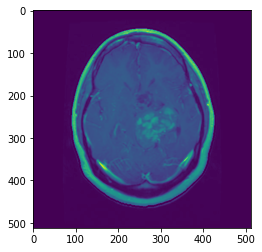

In [20]:
image = cv2.imread("Brain-MRI/Training/glioma_tumor/gg (1).jpg")

img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
img_thresh = cv2.erode(img_thresh, None, iterations=2)
img_thresh = cv2.dilate(img_thresh, None, iterations=2)

contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(contours)
image = cv2.drawContours(img_gray, contours, -1, (0, 0, 0), 3)
plt.imshow(image)
plt.show()

## Saving The Cropped Images 

In [21]:
# Crop the Training Images and Save it to the Directory we previously cretaed

for c in tqdm(classes):
  j = 0
  for i in os.listdir(train_dir +c):
    path = train_dir+c+"/"+i
    #path = os.path.jo-in(train_dir+c+"/"+i)
    #print(path)
    img = cv2.imread(path)
    cropped_image = crop_image(img , plot = False)
    save_path = "Crop-Brain-MRI/" + c + "/"+ str(j) + ".jpg"
    cv2.imwrite(save_path , cropped_image)
    j +=1
    #plt.imshow(cropped_image)
    #plt.show()


  
    

  

100%|██████████| 4/4 [01:12<00:00, 18.03s/it]


In [22]:
# Crop the Testing Images and Save it to the Directory we previously cretaed
for c in tqdm(classes):
  j = 0
  for i in tqdm(os.listdir(test_dir +c)):
    path = test_dir+c+"/"+i
    #path = os.path.jo-in(train_dir+c+"/"+i)
    #print(path)
    img = cv2.imread(path)
    cropped_image = crop_image(img , plot = False)
    save_path = "Test-data-MRI/" + c + "/"+ str(j) + ".jpg"
    cv2.imwrite(save_path , cropped_image)
    j +=1
    #plt.imshow(cropped_image)
    #plt.show()

100%|██████████| 4/4 [00:00<00:00,  5.58it/s]


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [55]:
# Use Image Data Generator to perform this task

datagen = ImageDataGenerator(rotation_range =10 , height_shift_range= 0.2 ,
                             horizontal_flip= True ,validation_split= 0.1)

train_data = datagen.flow_from_directory("Crop-Brain-MRI", target_size = (224,224) ,
                                         batch_size = 32 ,class_mode = "categorical", subset = "training")


valid_data = datagen.flow_from_directory("Crop-Brain-MRI", target_size = (224,224) ,
                                         batch_size = 32 ,class_mode = "categorical", subset = "validation")

test_datagen = ImageDataGenerator()

test_data = test_datagen.flow_from_directory("Test-data-MRI", target_size = (224,224) ,
                                         class_mode = "categorical")

Found 2940 images belonging to 4 classes.
Found 325 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [36]:
# View the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


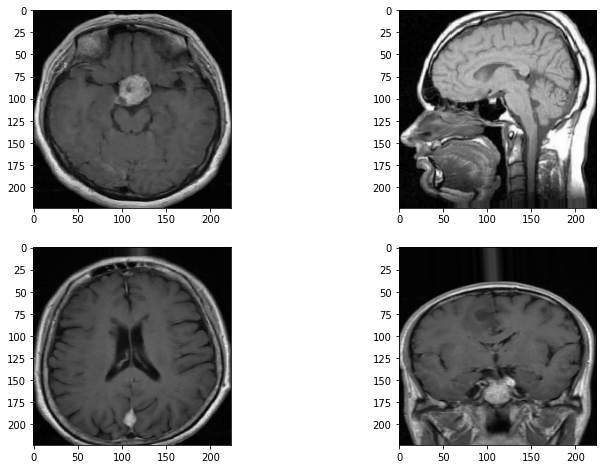

In [25]:
# View the augmented data.
sample_x , sample_y = next(train_data)
#print(type(sample_y))
plt.figure(figsize=(12,8))
for i in range(4):
  plt.subplot(2,2,i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('on')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Build and Compile the Model 

In [56]:
# Build the Model

base_model = EfficientNetB1(weights= "imagenet", include_top=False , input_shape=(224,224,3))
model = base_model.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs = base_model.input , outputs = model)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, 224, 224, 3)  7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_1[0][0]            
____________________________________________________________________________________________

In [73]:
model.compile(optimizer=Adam(learning_rate= 0.001),loss = "categorical_crossentropy", metrics =['accuracy'])
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",verbose= 1, save_best_only=True, mode="auto")
earlystop = EarlyStopping(monitor="val_loss",patience = 5, mode ="auto",verbose= 1)

## Model Training and Model Evaluation

In [74]:
# Train the model
model_train = model.fit(train_data ,epochs = 10 ,callbacks=[checkpoint,earlystop],validation_data=valid_data, verbose = 1)

Epoch 1/10
92/92 [==============================] - 928s 10s/step - loss: 0.4741 - accuracy: 0.8395 - val_loss: 1.7472 - val_accuracy: 0.6677

Epoch 00001: val_accuracy improved from -inf to 0.66769, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
92/92 [==============================] - 930s 10s/step - loss: 0.2155 - accuracy: 0.9245 - val_loss: 0.3857 - val_accuracy: 0.8862

Epoch 00002: val_accuracy improved from 0.66769 to 0.88615, saving model to model.h5
Epoch 3/10
92/92 [==============================] - 926s 10s/step - loss: 0.1481 - accuracy: 0.9500 - val_loss: 0.3001 - val_accuracy: 0.8985

Epoch 00003: val_accuracy improved from 0.88615 to 0.89846, saving model to model.h5
Epoch 4/10
92/92 [==============================] - 928s 10s/step - loss: 0.1301 - accuracy: 0.9571 - val_loss: 0.7673 - val_accuracy: 0.7846

Epoch 00004: val_accuracy did not improve from 0.89846
Epoch 5/10
92/92 [==============================] - 925s 10s/step - loss: 0.1279 - accuracy: 0.9595 - val_loss: 0.3190 - val_accuracy: 0.8954

Epoch 00005: val_accuracy did not improve from 0.89846
Epoch 6/10
92/92 [==============================] - 924s 10s/step - loss: 0.1212 - accuracy: 0.9626 - val_loss: 0.2339 - val_accuracy: 0.9200

Epoch

In [31]:
# Create a basic model instance

#model_train2 = create_model()

NameError: ignored

In [20]:
'''from keras.models import load_model
model_train = load_model('model.h1')'''

ValueError: ignored

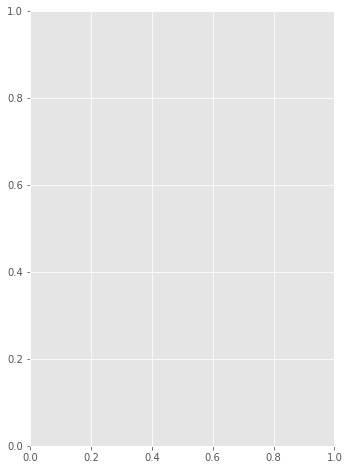

In [87]:
# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize = (12,8))
epochs = range(1,3)

plt.subplot(1,2,1)
plt.plot(epochs,model_train.history["accuracy"],"go--")
plt.plot(epochs,model_train.history["val_accuracy"],"ro--")
plt.xlabel("epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend(["Train","val"],loc ="upper left")

plt.subplot(1,2,2)
plt.plot(epochs,model_train.history["loss"],"go--")
plt.plot(epochs,model_train.history["val_loss"],"ro--")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Model loss")
plt.legend(["Train","val"],loc ="upper left")
plt.show()


In [79]:
# Evaluate the model on Test Set
model.evaluate(test_data)

1/1 [==============================] - 2s 2s/step - loss: 0.0610 - accuracy: 0.9500


[0.0609702542424202, 0.949999988079071]

## Obtaining Predictions on Test Images

ValueError: ignored

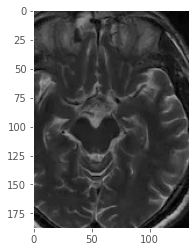

In [85]:
# Obtain Predictions on Test Images
#model = load_model("model.h5")

class_dict = {0 : "glioma tumor", 1 : "meningioma tumor" , 2: "no tumor" , 3:"pituitary tumor"}
test_img = cv2.imread("Data/no_tumor/3.jpg")
plt.imshow(test_img)
plt.grid(False)
test_img = np.expand_dims(test_img ,axis =0)
pred = model.predict(test_img)

pred = np.argmax(pred)

pred_class = class_dict[pred]
print(pred_class)